In [1]:
import scanpy as sc
import anndata as ad

In [75]:
combosciplex_color_dict = {
    'Alvespimycin+Pirarubicin': '#fa0e03',
    'Cediranib+PCI-34051': '#0d3290',
    'Dacinostat+Danusertib': '#33ff57',
    'Dacinostat+Dasatinib': '#6300b5',
    'Dacinostat+PCI-34051': '#88e200',
    'Givinostat+Carmofur': '#8e3101',
    'Givinostat+Cediranib': '#1F7530',
    'Givinostat+Crizotinib': '#6ca05c',
    'Givinostat+Curcumin': '#03cd4A',
    'Givinostat+Dasatinib': '#9106eb',
    'Givinostat+SRT1720': '#EB984E',
    'Givinostat+SRT2104': '#260374',
    'Givinostat+Sorafenib': '#ff5733', 
    'Givinostat+Tanespimycin': '#a3e3af',
    'Panobinostat+Alvespimycin': '#46adaf',
    'Panobinostat+Crizotinib': '#8E1382',
    'Panobinostat+Curcumin': '#bdfd0b',
    'Panobinostat+Dasatinib': '#ce606c',
    'Panobinostat+PCI-34051': '#795548',
    'Panobinostat+SRT1720': '#22bb34',
    'Panobinostat+SRT2104': '#8D6E63',
    'Panobinostat+SRT3025': '#9d8303',
    'Panobinostat+Sorafenib': '#d7fdfd',
    'SRT2104+Alvespimycin': '#f502f3',
    'SRT3025+Cediranib': '#f502f3',
    'control+Alvespimycin': '#6ea3fa',
    'control+Dacinostat': '#d6a5fa',
    'control+Dasatinib': '#2d62a3',
    'control+Givinostat': '#5deb2e',
    'control+Panobinostat': '#b1cd3f',
    'control+SRT2104': '#7788cd',
    'control': "#8f97a8"
}


In [3]:
split = 3

In [4]:
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")
adata_pred_test = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_test_with_predictions_{split}.h5ad")

In [5]:
adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]
adata_pred_test.X = adata_pred_test.layers["X_recon_pred"]

In [6]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [7]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [8]:
adata_ood = adata_ood[adata_ood.obs["condition"]!="control"]

In [9]:
adata_pred_ood.var_names = adata_ood.var_names
adata_pred_test.var_names = adata_test.var_names

In [10]:
bdata_ood = ad.concat((adata_train, adata_ood, adata_pred_ood), label="mode", keys=["train", "ood_true", "ood_pred"])

In [11]:
sc.pp.pca(bdata_ood)
sc.pp.neighbors(bdata_ood)
sc.tl.umap(bdata_ood)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


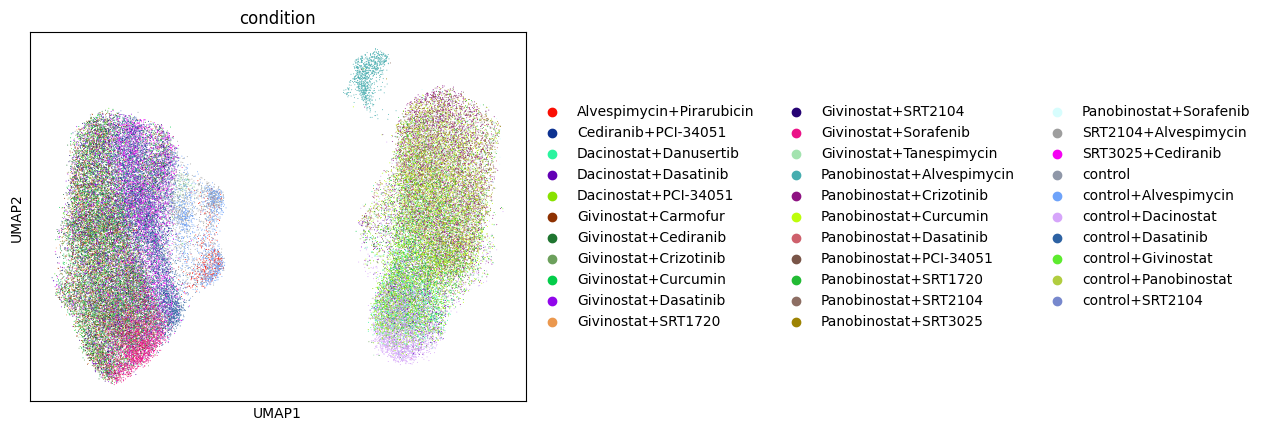

In [12]:
sc.pl.umap(bdata_ood, color=["condition"], palette=combosciplex_color_dict)

In [12]:
bdata_ood.obs["mode_with_control"] = bdata_ood.obs.apply(lambda x: "control" if x["condition"] == "control" else x["mode"], axis=1)

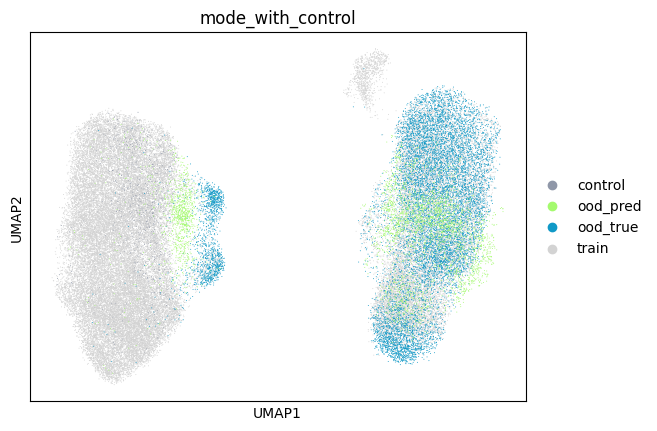

In [13]:
palette = {"control": "#8f97a8" , "ood_pred": "#a4fa6e" , "ood_true": "#1099c7" , "train": "#d3d3d3"}
sc.pl.umap(bdata_ood, color=["mode_with_control"], palette=palette)

In [65]:
def get_mode_condition(x):
    if x["mode"] == "train":
        return "train"
    return x["mode"] + "_" + x["condition"]

def get_condition_only(x, condition):
    if x["condition"] == condition:
        return x["condition"] + "_" + x["mode"]
    elif x["condition"] == "control":
        return "control"
    return "other"

In [66]:
bdata_ood.obs["mode_condition"] = bdata_ood.obs.apply(get_mode_condition, axis=1)

In [67]:
for cond in adata_ood.obs["condition"].cat.categories:
    bdata_ood.obs[cond] = bdata_ood.obs.apply(lambda x: get_condition_only(x, cond), axis=1)

In [85]:
palette = {}
for col in bdata_ood.obs[adata_ood.obs["condition"].cat.categories]:
    categories = bdata_ood.obs[col].unique()
    for cat in categories:
        if cat == "control":
            palette[cat] = combosciplex_color_dict["control"]
        if cat == "other":
            palette[cat] =  "#d3d3d3"
        elif "true" in cat:
            palette[cat] = combosciplex_color_dict[cat.split("_")[0]]
        elif "pred" in cat:
            palette[cat] = "#59d1d6"

In [86]:
categories

['other', 'control', 'control+Dacinostat_ood_true', 'control+Dacinostat_ood_pred']
Categories (4, object): ['control', 'control+Dacinostat_ood_pred', 'control+Dacinostat_ood_true', 'other']

In [87]:
conditions = list(set(adata_ood.obs["condition"].cat.categories) - set(('control',)))

In [88]:
conditions

['Panobinostat+Curcumin',
 'control+Dacinostat',
 'Panobinostat+Crizotinib',
 'Panobinostat+SRT1720',
 'SRT2104+Alvespimycin',
 'control+Alvespimycin',
 'Panobinostat+Sorafenib']

In [89]:
palette

{'other': '#d3d3d3',
 'control': '#8f97a8',
 'Panobinostat+Crizotinib_ood_true': '#8E1382',
 'Panobinostat+Crizotinib_ood_pred': '#59d1d6',
 'Panobinostat+Curcumin_ood_true': '#bdfd0b',
 'Panobinostat+Curcumin_ood_pred': '#59d1d6',
 'Panobinostat+SRT1720_ood_true': '#22bb34',
 'Panobinostat+SRT1720_ood_pred': '#59d1d6',
 'Panobinostat+Sorafenib_ood_true': '#d7fdfd',
 'Panobinostat+Sorafenib_ood_pred': '#59d1d6',
 'SRT2104+Alvespimycin_ood_true': '#f502f3',
 'SRT2104+Alvespimycin_ood_pred': '#59d1d6',
 'control+Alvespimycin_ood_true': '#6ea3fa',
 'control+Alvespimycin_ood_pred': '#59d1d6',
 'control+Dacinostat_ood_true': '#d6a5fa',
 'control+Dacinostat_ood_pred': '#59d1d6'}

In [90]:
bdata_ood.obs.head()

,condition,mode,mode_condition,Panobinostat+Crizotinib,Panobinostat+Curcumin,Panobinostat+SRT1720,Panobinostat+Sorafenib,SRT2104+Alvespimycin,control+Alvespimycin,control+Dacinostat
A01_A02_RT_BC_10_Lig_BC_18,control+Panobinostat,train,train,other,other,other,other,other,other,other
A01_A02_RT_BC_10_Lig_BC_25,control+Panobinostat,train,train,other,other,other,other,other,other,other
A01_A02_RT_BC_10_Lig_BC_48,control+Panobinostat,train,train,other,other,other,other,other,other,other
A01_A02_RT_BC_10_Lig_BC_51,control+Panobinostat,train,train,other,other,other,other,other,other,other
A01_A02_RT_BC_10_Lig_BC_72,control+Panobinostat,train,train,other,other,other,other,other,other,other


In [94]:
import functools
def get_size(x, cond):
    if x["condition"] == "control":
        return 15.0
    if x[cond] == "other":
        return 2.0
    else:
        return 15.0
cond = "Panobinostat+Curcumin"


In [95]:
palette

{'other': '#d3d3d3',
 'control': '#8f97a8',
 'Panobinostat+Crizotinib_ood_true': '#8E1382',
 'Panobinostat+Crizotinib_ood_pred': '#59d1d6',
 'Panobinostat+Curcumin_ood_true': '#bdfd0b',
 'Panobinostat+Curcumin_ood_pred': '#59d1d6',
 'Panobinostat+SRT1720_ood_true': '#22bb34',
 'Panobinostat+SRT1720_ood_pred': '#59d1d6',
 'Panobinostat+Sorafenib_ood_true': '#d7fdfd',
 'Panobinostat+Sorafenib_ood_pred': '#59d1d6',
 'SRT2104+Alvespimycin_ood_true': '#f502f3',
 'SRT2104+Alvespimycin_ood_pred': '#59d1d6',
 'control+Alvespimycin_ood_true': '#6ea3fa',
 'control+Alvespimycin_ood_pred': '#59d1d6',
 'control+Dacinostat_ood_true': '#d6a5fa',
 'control+Dacinostat_ood_pred': '#59d1d6'}

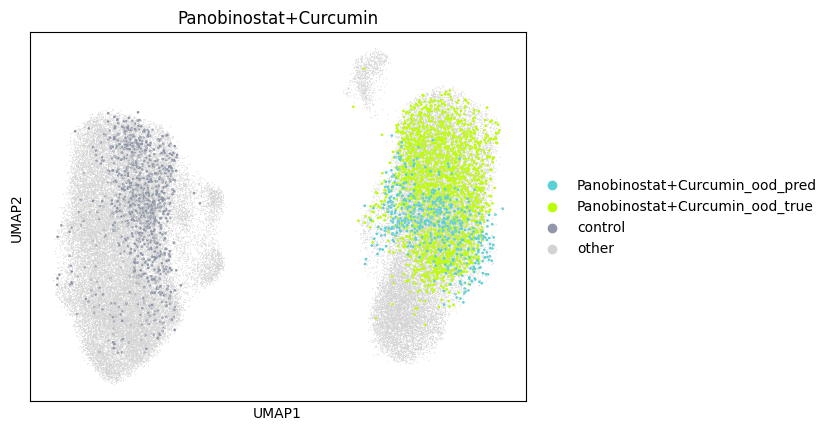

In [96]:
cond =  conditions[0]
sizes = bdata_ood.obs.apply(functools.partial(get_size, cond=cond), axis=1)
sc.pl.umap(bdata_ood, color=cond, palette=palette, size=sizes.values)

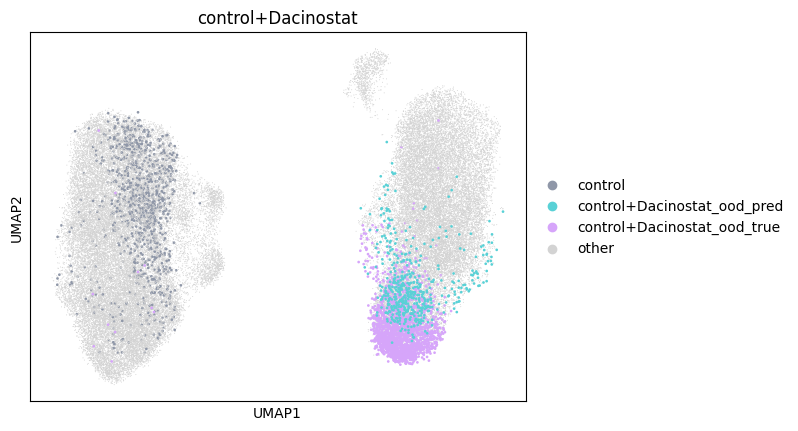

In [97]:
cond =  conditions[1]
sizes = bdata_ood.obs.apply(functools.partial(get_size, cond=cond), axis=1)
sc.pl.umap(bdata_ood, color=cond, palette=palette, size=sizes.values)

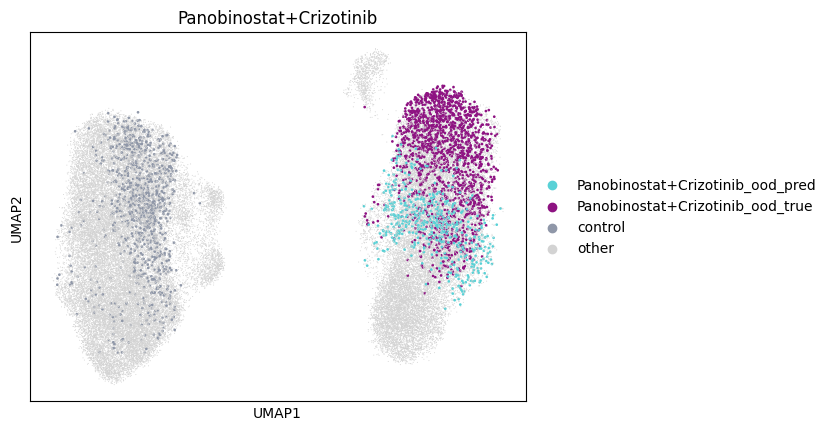

In [98]:
cond =  conditions[2]
sizes = bdata_ood.obs.apply(functools.partial(get_size, cond=cond), axis=1)
sc.pl.umap(bdata_ood, color=cond, palette=palette, size=sizes.values)

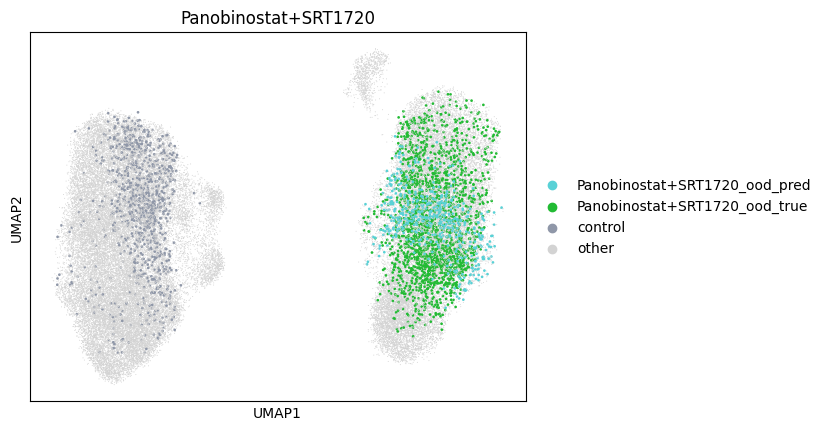

In [99]:
cond =  conditions[3]
sizes = bdata_ood.obs.apply(functools.partial(get_size, cond=cond), axis=1)
sc.pl.umap(bdata_ood, color=cond, palette=palette, size=sizes.values)

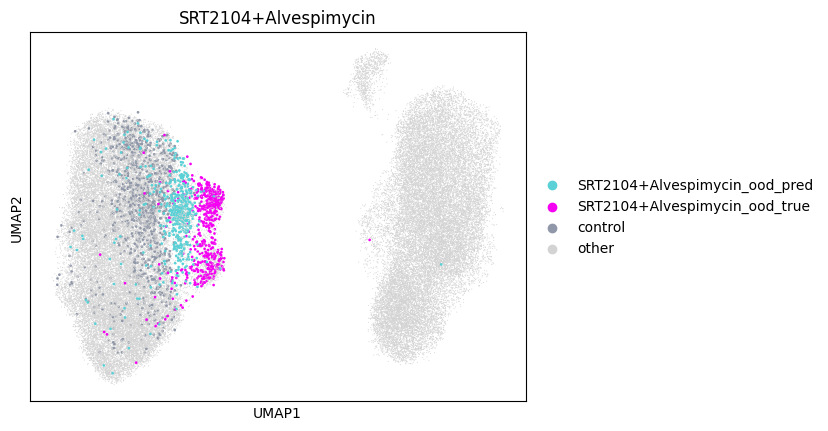

In [100]:
cond =  conditions[4]
sizes = bdata_ood.obs.apply(functools.partial(get_size, cond=cond), axis=1)
sc.pl.umap(bdata_ood, color=cond, palette=palette, size=sizes.values)

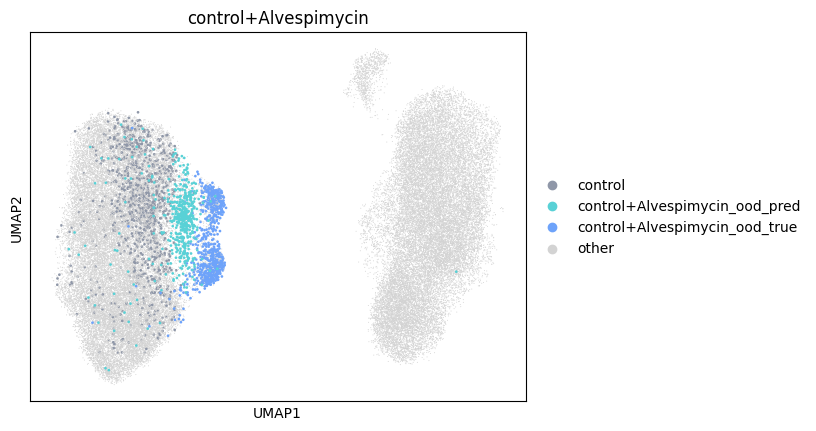

In [101]:
cond =  conditions[5]
sizes = bdata_ood.obs.apply(functools.partial(get_size, cond=cond), axis=1)
sc.pl.umap(bdata_ood, color=cond, palette=palette, size=sizes.values)

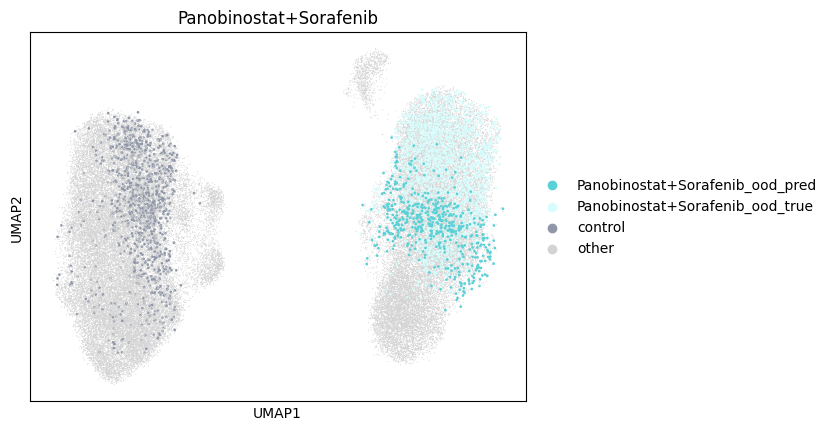

In [102]:
cond =  conditions[6]
sizes = bdata_ood.obs.apply(functools.partial(get_size, cond=cond), axis=1)
sc.pl.umap(bdata_ood, color=cond, palette=palette, size=sizes.values)

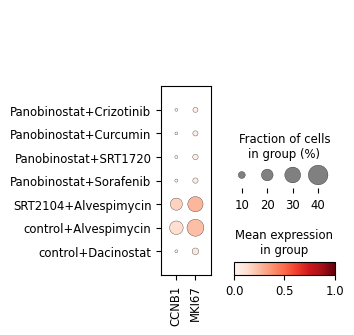

In [20]:
sc.pl.dotplot(adata_ood[adata_ood.obs["condition"]!="control"], ["CCNB1", "MKI67"], groupby="condition", vmin=0.0, vmax=1.0, expression_cutoff=0.1)


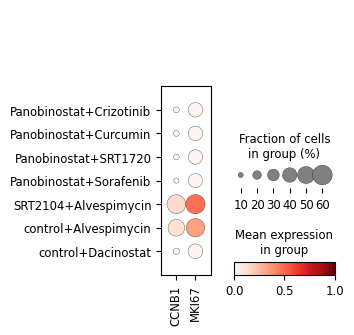

In [21]:
sc.pl.dotplot(adata_pred_ood, ["CCNB1", "MKI67"], groupby="condition", vmin=0.0, vmax=1.0, expression_cutoff=0.1)

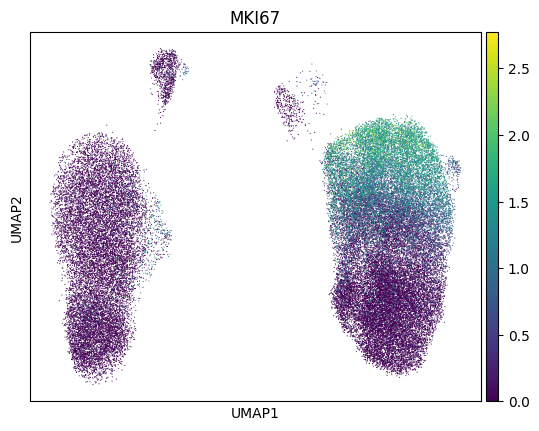

In [22]:
sc.pl.umap(adata_train, color=["MKI67"])
